<a href="https://colab.research.google.com/github/Jackie-ZHU-cloud/math5470-zhu-song-Final-Project/blob/main/XGBoost_And_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow

import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


import warnings
warnings.filterwarnings("ignore")

### Extract zip and save to Google Drive

In [ ]:
from google.colab import drive
import os
import sys
import zipfile
from pathlib import Path


BASE_PATH = Path("/content")


def extract_data():
    """
    功能：挂载 Google Drive 并解压数据集到 Colab 本地环境
    """
    print("正在挂载 Google Drive...")
    drive.mount('/content/drive')

    ZIP_FILE_PATH = '/content/drive/MyDrive/Jane Street Dataset/jane-street-real-time-market-data-forecasting.zip'
    PATH_DATA = BASE_PATH / "unzipped_data"

    # 添加路径以便后续可能得引用
    sys.path.append(str(PATH_DATA))
    os.makedirs(PATH_DATA, exist_ok=True)

    # 检查解压后的文件是否存在，不存在则解压
    if not (PATH_DATA / "train.parquet").exists():
        if os.path.exists(ZIP_FILE_PATH):
            print(f"发现压缩包：{ZIP_FILE_PATH}，正在解压...")
            with zipfile.ZipFile(ZIP_FILE_PATH, 'r') as zip_ref:
                zip_ref.extractall(PATH_DATA)
            print("解压完成。")
        else:
            print("错误：未在 Google Drive 找到 Zip 文件，请检查路径。")
    else:
        print("数据文件已存在，跳过解压步骤。")

    return PATH_DATA

# 执行数据解压
DATA_DIR = extract_data()

正在挂载 Google Drive...
Mounted at /content/drive
发现压缩包：/content/drive/MyDrive/Jane Street Dataset/jane-street-real-time-market-data-forecasting.zip，正在解压...


KeyboardInterrupt: 

In [ ]:
import os
import shutil
from pathlib import Path

# 1. 定义源文件路径 (当前 Colab 本地路径)
# 也就是你之前解压出来的那个文件
SOURCE_FILE = Path("/content/unzipped_data/train.parquet/partition_id=0/part-0.parquet")

# 2. 定义目标路径 (Google Drive 路径)
# 我们在 Drive 里创建一个叫 "parquet_data" 的文件夹专门放解压后的数据
DRIVE_SAVE_DIR = Path("/content/drive/MyDrive/Jane Street Dataset/parquet_data")
TARGET_FILE = DRIVE_SAVE_DIR / "train_part_0.parquet"

print(f"Source: {SOURCE_FILE}")
print(f"Target: {TARGET_FILE}")

# 3. 开始复制
if SOURCE_FILE.exists():
    print(f"\nCreating directory: {DRIVE_SAVE_DIR}")
    os.makedirs(DRIVE_SAVE_DIR, exist_ok=True)

    print("Copying file... (This may take a minute depending on file size)")
    # 使用 copy2 保留文件元数据
    shutil.copy2(SOURCE_FILE, TARGET_FILE)

    print("\n✅ Success! File saved to Google Drive.")
    print(f"File size: {os.path.getsize(TARGET_FILE) / (1024*1024):.2f} MB")
else:
    print(f"\n❌ Error: Source file not found at {SOURCE_FILE}")
    print("Please make sure you have run the extract_data() function first.")

Source: /content/unzipped_data/train.parquet/partition_id=0/part-0.parquet
Target: /content/drive/MyDrive/Jane Street Dataset/parquet_data/train_part_0.parquet

Creating directory: /content/drive/MyDrive/Jane Street Dataset/parquet_data
Copying file... (This may take a minute depending on file size)

✅ Success! File saved to Google Drive.
File size: 448.55 MB


In [ ]:
TRAIN_PARQUET_PATH = DATA_DIR / "train.parquet/partition_id=0/part-0.parquet"
# Here are over 9 partition_ids for trian.parquet

df = pd.read_parquet(TRAIN_PARQUET_PATH)
df.head(5)

# missing_values = df.isnull().sum().reset_index()
# missing_values.columns = ['Column', 'Missing Values']

# Display columns with missing values only
# missing_values[missing_values['Missing Values'] > 0]

# print(df.describe())

,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,...,feature_78,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8
0,0,0,1,3.889038,NaN,NaN,NaN,NaN,NaN,0.851033,...,-0.281498,0.738489,-0.069556,1.380875,2.005353,0.186018,1.218368,0.775981,0.346999,0.095504
1,0,0,7,1.370613,NaN,NaN,NaN,NaN,NaN,0.676961,...,-0.302441,2.965889,1.190077,-0.523998,3.849921,2.626981,5.000000,0.703665,0.216683,0.778639
2,0,0,9,2.285698,NaN,NaN,NaN,NaN,NaN,1.056285,...,-0.096792,-0.864488,-0.280303,-0.326697,0.375781,1.271291,0.099793,2.109352,0.670881,0.772828
3,0,0,10,0.690606,NaN,NaN,NaN,NaN,NaN,1.139366,...,-0.296244,0.408499,0.223992,2.294888,1.097444,1.225872,1.225376,1.114137,0.775199,-1.379516
4,0,0,14,0.440570,NaN,NaN,NaN,NaN,NaN,0.955200,...,3.418133,-0.373387,-0.502764,-0.348021,-3.928148,-1.591366,-5.000000,-3.572820,-1.089123,-5.000000


### Load Dataset from Drive

In [ ]:
from google.colab import drive
import pandas as pd
from pathlib import Path


drive.mount('/content/drive')

PARQUET_PATH = "/content/drive/MyDrive/Jane Street Dataset/parquet_data/train_part_0.parquet"
path_obj = Path(PARQUET_PATH)

if path_obj.exists():
    print(f"Loading data directly from Drive: {PARQUET_PATH}")
    df = pd.read_parquet(PARQUET_PATH)
    print("Data loaded successfully!")
    print(df.head())
else:
    print("File not found. Please unzip and save it first.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading data directly from Drive: /content/drive/MyDrive/Jane Street Dataset/parquet_data/train_part_0.parquet
Data loaded successfully!
   date_id  time_id  symbol_id    weight  feature_00  feature_01  feature_02  \
0        0        0          1  3.889038         NaN         NaN         NaN   
1        0        0          7  1.370613         NaN         NaN         NaN   
2        0        0          9  2.285698         NaN         NaN         NaN   
3        0        0         10  0.690606         NaN         NaN         NaN   
4        0        0         14  0.440570         NaN         NaN         NaN   

   feature_03  feature_04  feature_05  ...  feature_78  responder_0  \
0         NaN         NaN    0.851033  ...   -0.281498     0.738489   
1         NaN         NaN    0.676961  ...   -0.302441     2.965889   
2         NaN         NaN    1.056285  .

## Dropping Columns with All Null Values from DataFrame


In [ ]:
# Identify columns where all values are null
null_columns = df.columns[df.isnull().all()]

# Print the names of the columns that will be dropped
# print(f"Columns with all null values: {null_columns.tolist()}")

df_cleaned = df.drop(columns=null_columns)

print(f"Original shape: {df.shape}")
print(f"Shape after dropping null columns: {df_cleaned.shape}")

# print("Remaining columns with all null values (if any):")
# print(df_cleaned.isnull().all()[df_cleaned.isnull().all()])

# df_cleaned.head()

missing_values = df_cleaned.isnull().sum().reset_index()
missing_values.columns = ['Column', 'Missing Values']

# Display columns with missing values only
print("total number of columns having any row as null:", len(missing_values[missing_values['Missing Values'] > 0]))

Original shape: (1944210, 92)
Shape after dropping null columns: (1944210, 83)
total number of columns having any row as null: 35


In [ ]:
from sklearn.impute import SimpleImputer

# Define the target column
target_column = 'responder_6'

# Separate features and target
X = df_cleaned.drop(columns=[target_column])  # Features
y = df_cleaned[target_column]  # Target variable

# Create a SimpleImputer (faster than KNNImputer)
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Create a new DataFrame with imputed values
df_imputed = pd.DataFrame(X_imputed, columns=X.columns)
df_imputed[target_column] = y.reset_index(drop=True)  # Add the target column back

df_cleaned = df_imputed

missing_values = df_cleaned.isnull().sum().reset_index()
missing_values.columns = ['Column', 'Missing Values']

# Display columns with missing values only
print("total number of columns having any row as null:", len(missing_values[missing_values['Missing Values'] > 0]))

total number of columns having any row as null: 0


## Visualizing Distributions of Features and Responders

正在绘制 Features 的分布图...
正在绘制第 0 个分布图...
正在绘制第 1 个分布图...
正在绘制第 2 个分布图...
正在绘制第 3 个分布图...
正在绘制第 4 个分布图...
正在绘制第 5 个分布图...
正在绘制第 6 个分布图...
正在绘制第 7 个分布图...


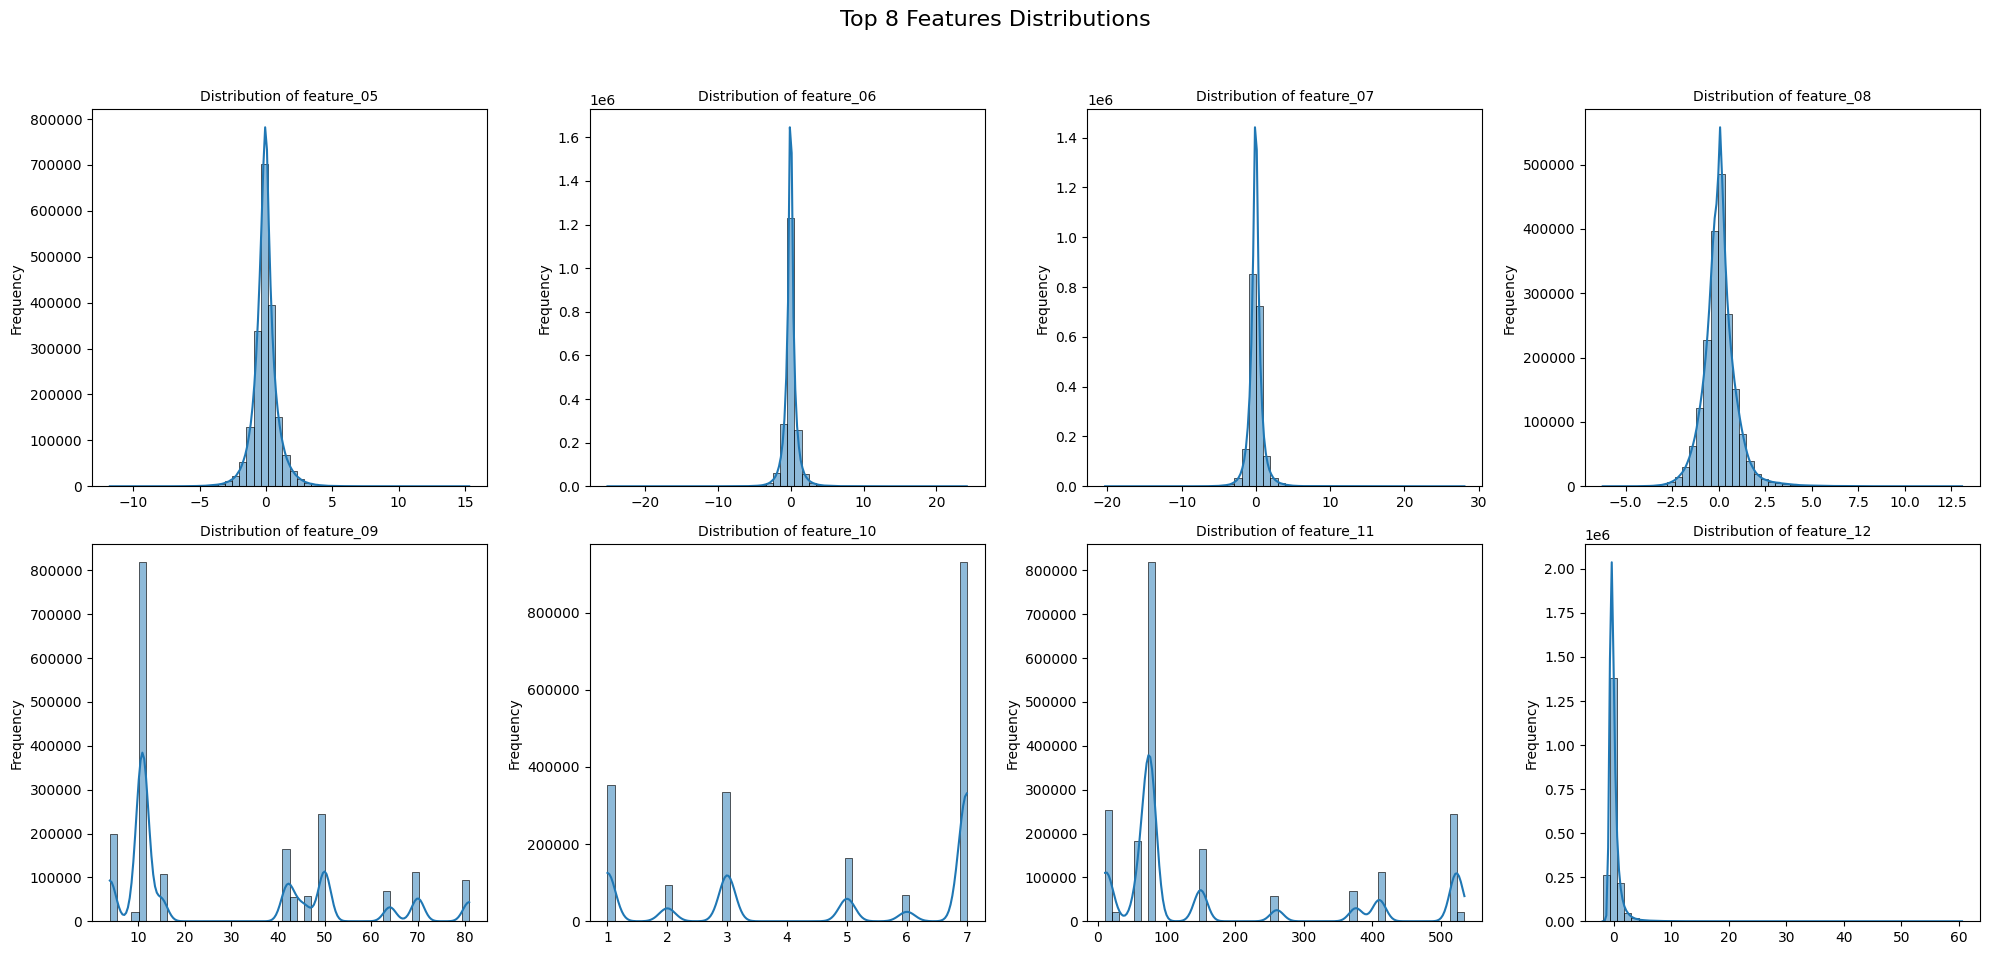

正在绘制 Responders 的分布图...
正在绘制第 0 个分布图...
正在绘制第 1 个分布图...
正在绘制第 2 个分布图...
正在绘制第 3 个分布图...
正在绘制第 4 个分布图...
正在绘制第 5 个分布图...
正在绘制第 6 个分布图...
正在绘制第 7 个分布图...


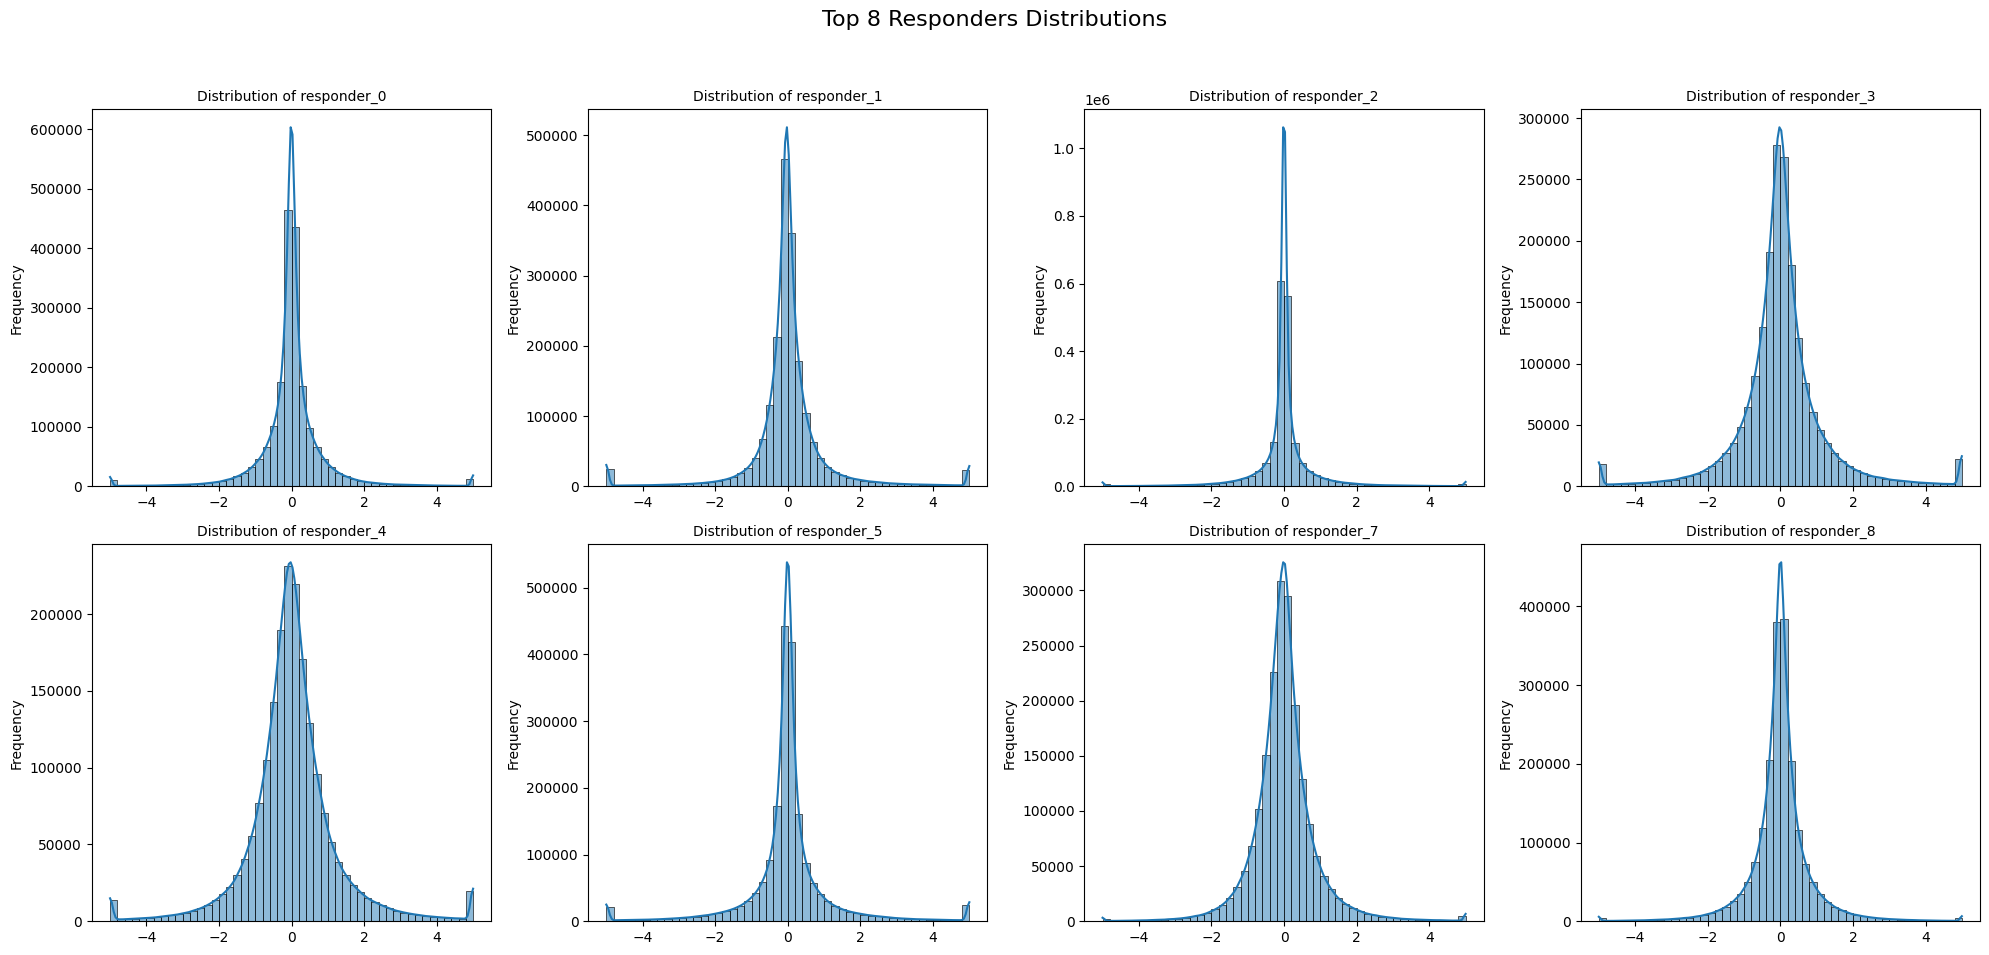

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

# 筛选前 8 个 Feature 和 Responder
all_features = [col for col in df_cleaned.columns if 'feature' in col]
all_responders = [col for col in df_cleaned.columns if 'responder' in col]

top_8_features = all_features[:8]
top_8_responders = all_responders[:8]

# 定义一个通用的绘图函数
def plot_grid(data, columns, group_name):
    n_cols = 4  # 每排 4 个
    n_rows = 2  # 共 2 排

    # 创建画布，大小调整为宽一些，适应 4 列
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 10))
    axes = axes.flatten()  # 扁平化以便遍历

    print(f"正在绘制 {group_name} 的分布图...")

    for i, col in enumerate(columns):
        if i >= len(axes): break # 防止越界

        print(f"正在绘制第 {i} 个分布图...")

        # 绘图
        sns.histplot(data[col], bins=50, kde=True, ax=axes[i])

        # 设置标题和标签
        axes[i].set_title(f'Distribution of {col}', fontsize=10)
        axes[i].set_xlabel('') # 省略 x 轴标签以显得更整洁
        axes[i].set_ylabel('Frequency')

    # 如果列数少于 8 个，隐藏多余的子图
    for j in range(len(columns), len(axes)):
        axes[j].axis('off')

    # 添加总标题并调整布局
    fig.suptitle(f'Top 8 {group_name} Distributions', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # 留出顶部空间给 suptitle
    plt.show()


# 第一张图：前 8 个 Features
if len(top_8_features) > 0:
    plot_grid(df_cleaned, top_8_features, "Features")
else:
    print("未找到 Feature 列")

# 第二张图：前 8 个 Responders
if len(top_8_responders) > 0:
    plot_grid(df_cleaned, top_8_responders, "Responders")
else:
    print("未找到 Responder 列")

# Heatmaps

#### heatmap between features and all responders

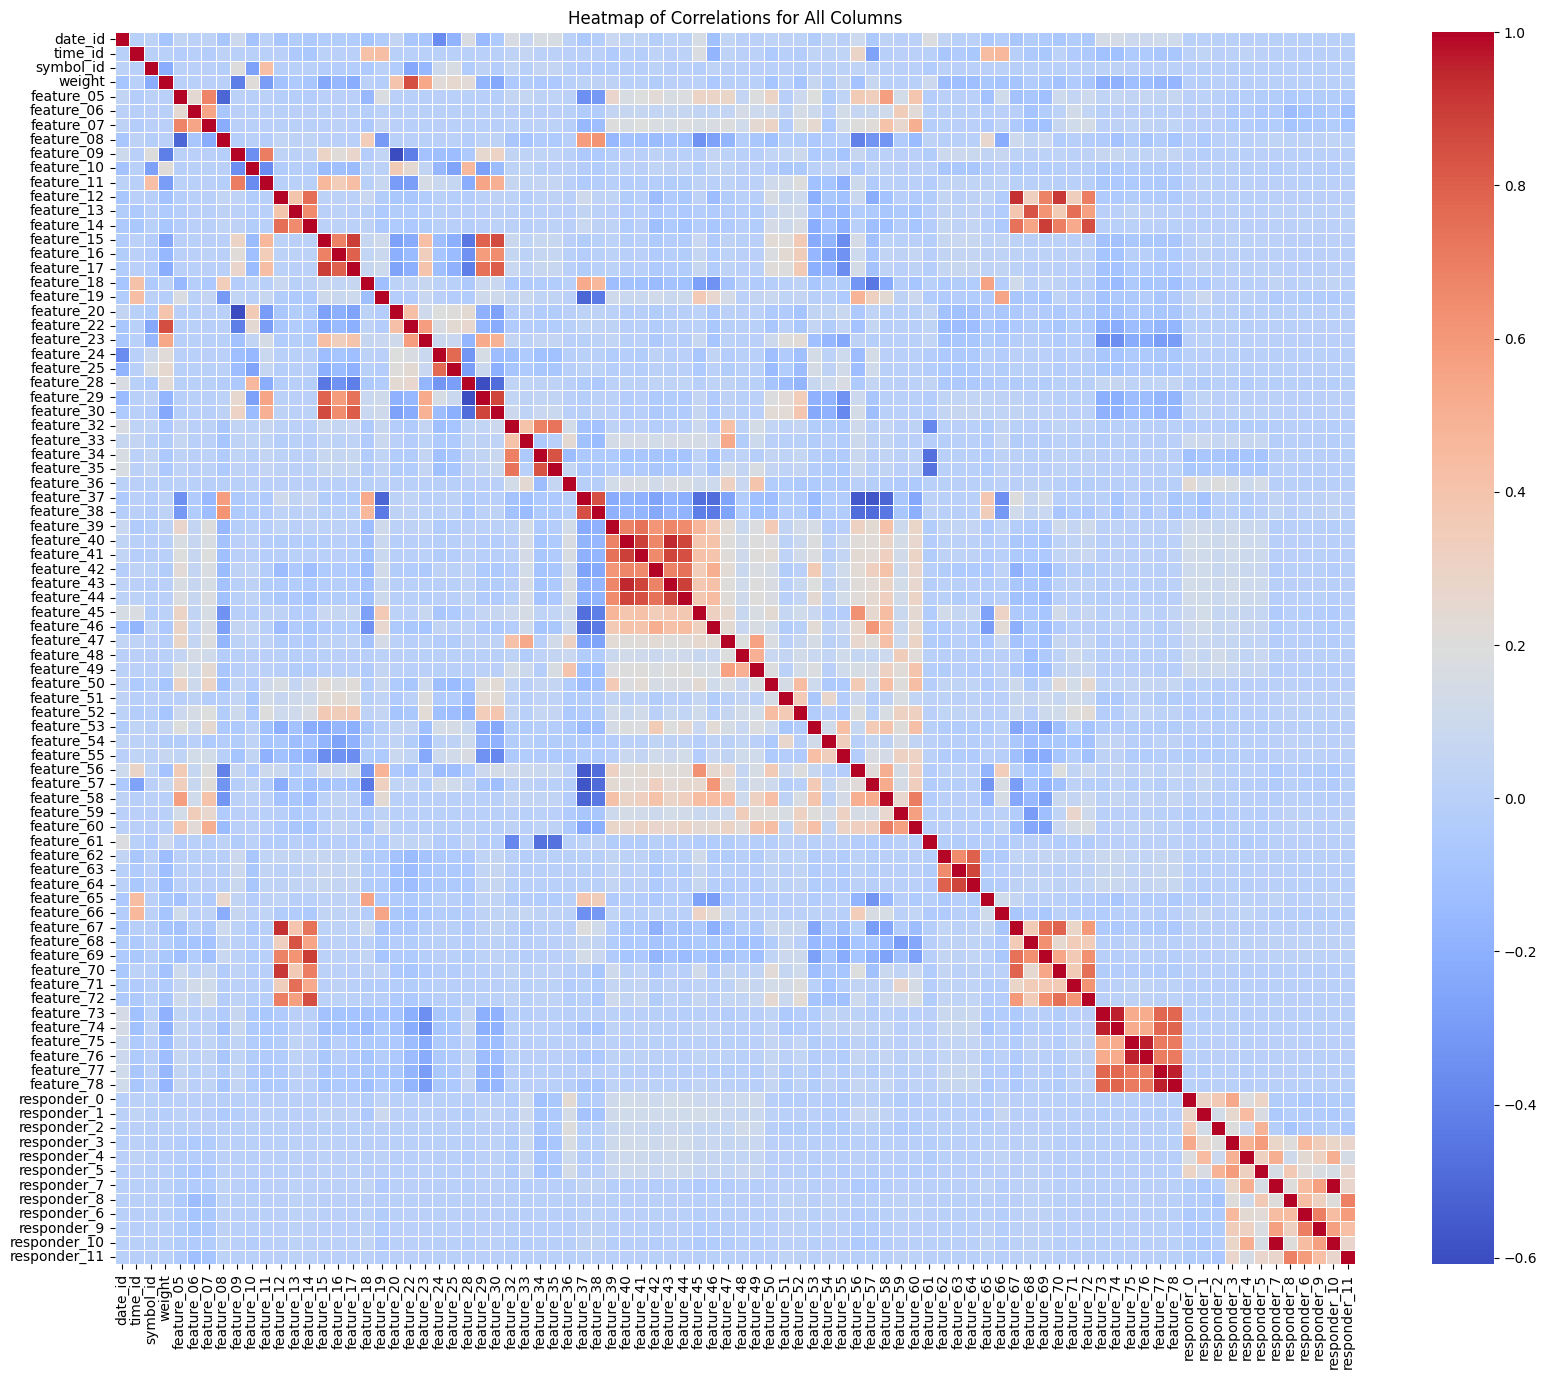

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


data = df_cleaned

# Set up the figure size for a large heatmap
plt.figure(figsize=(20, 16))

# Generate the heatmap for the entire dataset
# heatmap between features and all responders
sns.heatmap(data.corr(), annot=False, cmap='coolwarm', linewidths=0.5)

# Add title
plt.title('Heatmap of Correlations for All Columns')
plt.show()


#### Heatmap for the target variable (responder_6)

正在计算相关性矩阵...
最相关的 10 个特征: ['feature_06', 'feature_07', 'feature_05', 'feature_19', 'feature_68', 'feature_08', 'feature_51', 'feature_56', 'feature_38', 'feature_37']


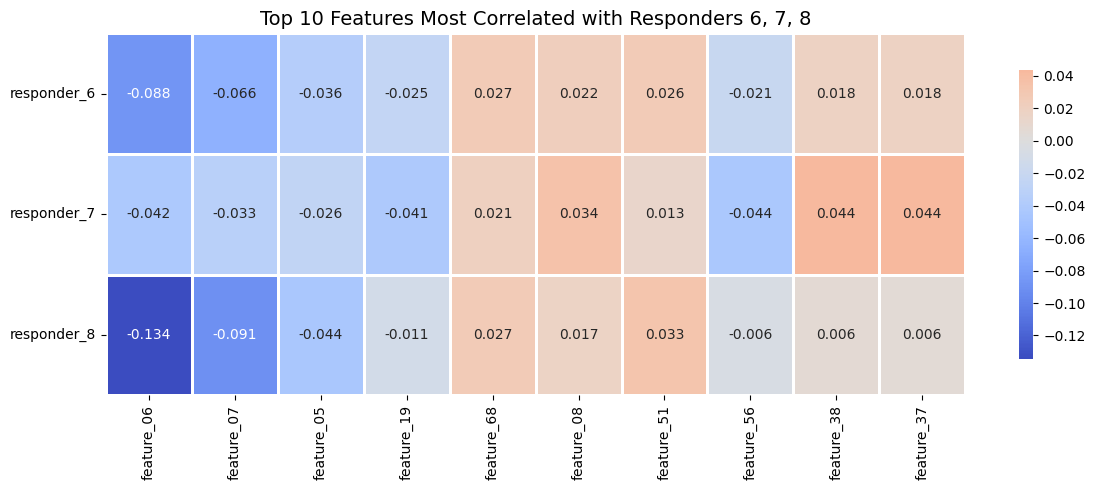

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. 定义目标和特征
targets = ['responder_6', 'responder_7', 'responder_8']
features = [col for col in df_cleaned.columns if 'feature_' in col]

# 2. 计算相关性矩阵
# 我们只关心 Targets 和 Features 之间的关系
# 注意：这里计算的是 Pearson 相关系数
print("正在计算相关性矩阵...")
subset_df = df_cleaned[targets + features]
corr_matrix = subset_df.corr()

# 3. 筛选逻辑
# 从大矩阵中，只截取 [Targets] 行 和 [Features] 列
target_feature_corr = corr_matrix.loc[targets, features]

# 计算“重要性得分”：每个 Feature 与这 3 个 Responder 的绝对相关系数的平均值
# (取绝对值是因为负相关 -0.8 和正相关 0.8 一样重要)
importance_score = target_feature_corr.abs().mean(axis=0)

# 找出得分最高的 Top 10 Feature 的名字
top_10_features = importance_score.sort_values(ascending=False).head(10).index.tolist()

print(f"最相关的 10 个特征: {top_10_features}")

# 4. 准备绘图数据
# 提取出最终用于绘图的小矩阵 (3行 x 10列)
plot_data = target_feature_corr[top_10_features]

# 5. 绘制精简版热力图
plt.figure(figsize=(12, 5))

sns.heatmap(
    plot_data,
    annot=True,         # 显示数值
    fmt=".3f",          # 保留3位小数
    cmap='coolwarm',    # 冷暖色调：红正蓝负
    center=0,           # 0 值对应白色/中间色
    linewidths=1,       # 格子边框
    cbar_kws={"shrink": 0.8} # 调整图例大小
)

plt.title('Top 10 Features Most Correlated with Responders 6, 7, 8', fontsize=14)
plt.yticks(rotation=0)  # 让纵轴标签水平显示
plt.tight_layout()
plt.show()

# **XGBoost for Time Series Analysis**

R-squared: 0.0149
Mean Absolute Error (MAE): 0.6576
Mean Squared Error (MSE): 0.9780
Root Mean Squared Error (RMSE): 0.9890
Mean Absolute Percentage Error (MAPE): 235.65%
Custom Accuracy (within 10% of actual): 1.17%


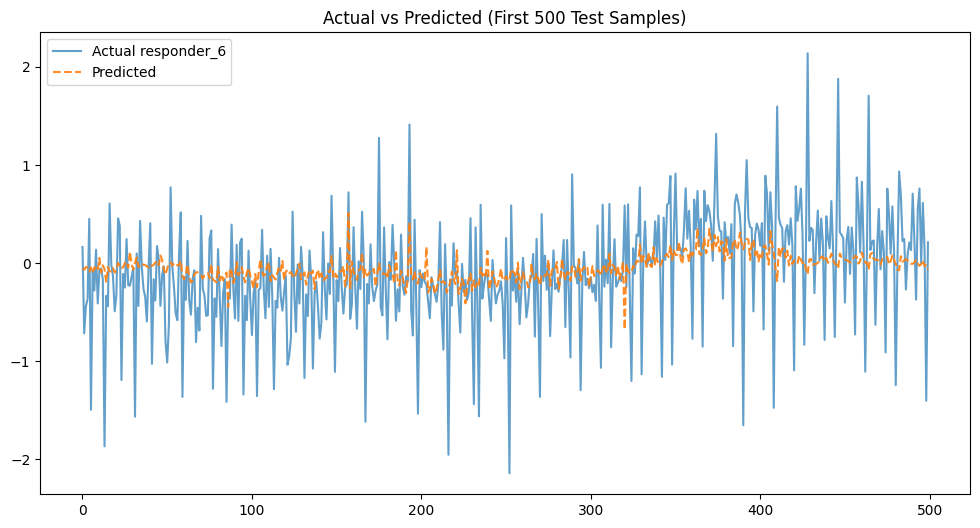

In [ ]:
df_sample = df_cleaned

# Step 2: Select Features and Target
# Here 'responder_6' is the target variable
target = 'responder_6'
features = [col for col in df_sample.columns if 'feature_' in col]

X = df_sample[features]  # Feature matrix
y = df_sample[target]    # Target variable

# Step 3: Train-Test Split
# Since this could be time-series data, make sure to split carefully
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Step 4: Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: Model Training (XGBoost)
model = XGBRegressor(objective='reg:squarederror', n_estimators=50, learning_rate=0.1)  # Reduced estimators for faster testing
model.fit(X_train_scaled, y_train)

# Step 6: Model Prediction
y_pred = model.predict(X_test_scaled)

# Step 7: Calculate Evaluation Metrics

# R-squared
r2 = r2_score(y_test, y_pred)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

# Custom Accuracy: Percentage of predictions within 10% of the actual values
accuracy = np.mean(np.abs((y_pred - y_test) / y_test) < 0.10) * 100

# Step 8: Print all metrics
print(f"R-squared: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Custom Accuracy (within 10% of actual): {accuracy:.2f}%")


import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test.reset_index(drop=True)[:500],
         label='Actual responder_6', alpha=0.7)
plt.plot(y_pred[:500], label='Predicted', alpha=0.9, linestyle='--')
plt.title('Actual vs Predicted (First 500 Test Samples)')
plt.legend()
plt.show()


In [ ]:
# Select the specific row (e.g., row 89) as a sample input
sample_input = df.loc[[89], features]  # Use double brackets to maintain DataFrame structure

# Step 10: Scale the Sample Input
sample_input_scaled = scaler.transform(sample_input)

# Step 11: Make Predictions
sample_predictions = model.predict(sample_input_scaled)

# Step 12: Display Predictions
print("Sample Input Data:")
print(sample_input)
print("\nPredicted Value for Sample Input:")
print(sample_predictions)

Sample Input Data:
    feature_05  feature_06  feature_07  feature_08  feature_09  feature_10  \
89    0.653724   -0.084745    0.119095   -0.564572          11           7   

    feature_11  feature_12  feature_13  feature_14  ...  feature_69  \
89          76   -1.114549    -0.35649   -0.583195  ...   -0.164523   

    feature_70  feature_71  feature_72  feature_73  feature_74  feature_75  \
89   -0.978206   -0.312797   -0.624864   -0.498919   -0.348725   -0.277771   

    feature_76  feature_77  feature_78  
89   -0.250952   -0.357971   -0.194685  

[1 rows x 70 columns]

Predicted Value for Sample Input:
[-0.6979831]


### XGBoost Aux Targets Augment

Constructing Auxiliary Targets (Pandas version of Polars logic)...
Auxiliary Targets Created.

Starting Stage 1: Training Auxiliary Models...
  Training Model for responder_8...
  Training Model for responder_9...
  Training Model for responder_10...
  Training Model for responder_11...
Stage 1 Complete.

Starting Stage 2: Training Linear Layer (Stacking)...
Generating Final Predictions...

FINAL RESULTS (Stacked XGBoost + Linear)
R-squared: 0.008114
MSE      : 0.984760
RMSE     : 0.992351

Linear Layer Weights (Contribution of each auxiliary target):
  responder_8: -0.4123
  responder_9: 1.0876
  responder_10: 0.5976
  responder_11: 0.5380


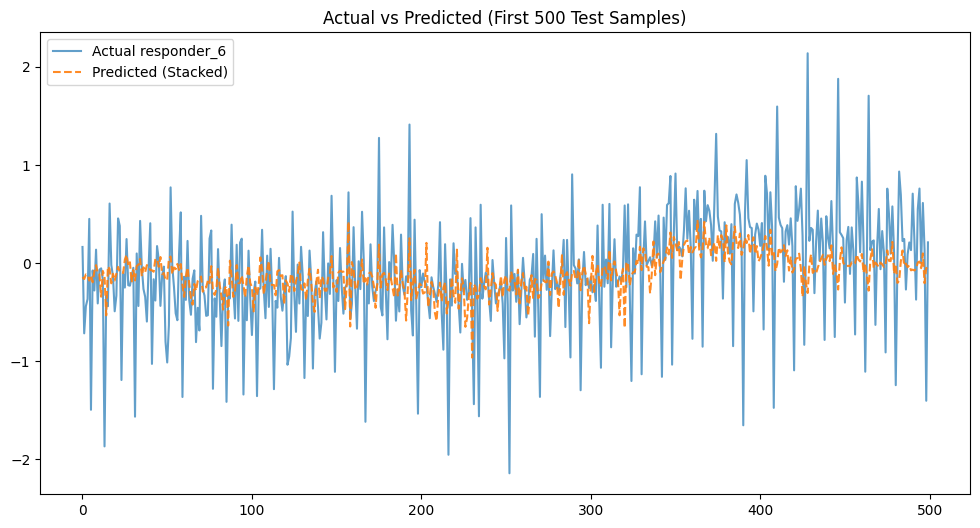

In [ ]:
from sklearn.linear_model import Ridge
import tensorflow as tf
import gc

print("Constructing Auxiliary Targets (Pandas version of Polars logic)...")

if 'symbol_id' not in df_cleaned.columns and 'symbol_id' in df.columns:
    df_cleaned['symbol_id'] = df['symbol_id']

# Auxiliary Targets (responder_9 responder_10)
grouped = df_cleaned.groupby('symbol_id')


df_cleaned['responder_6_lag20'] = grouped['responder_6'].shift(-20)
df_cleaned['responder_9'] = (
    df_cleaned['responder_6'] +
    df_cleaned['responder_6_lag20']
    # + df_cleaned['responder_6_lag40']
).fillna(0.0)

df_cleaned['responder_7_lag120'] = grouped['responder_7'].shift(-120)
df_cleaned['responder_10'] = (  # try with raw responder 7 only
    df_cleaned['responder_7']
    # + df_cleaned['responder_7_lag120']
).fillna(0.0)

df_cleaned['responder_8_lag4'] = grouped['responder_8'].shift(-4)
df_cleaned['responder_11'] = (
    df_cleaned['responder_8'] +
    df_cleaned['responder_8_lag4']
).fillna(0.0)


df_cleaned.drop(columns=[
    'responder_6_lag20',
    'responder_7_lag120',
    'responder_8_lag4'
], inplace=True)

print("Auxiliary Targets Created.")

# Step 2: Select Features and Targets
feature_cols = [col for col in df_cleaned.columns if 'feature_' in col]

target_cols = [
    'responder_8', 'responder_9',
    'responder_10', 'responder_11'
]
main_target = 'responder_6'


train_df = df_cleaned.dropna(subset=target_cols + [main_target])

X = train_df[feature_cols]
Ys = train_df[target_cols + [main_target]]

# Step 3: Train-Test Split (Time Series Split)
split_idx = int(len(train_df) * 0.8)

X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
Y_train, Y_test = Ys.iloc[:split_idx], Ys.iloc[split_idx:]

# Step 4: Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

stage1_train_preds = pd.DataFrame(index=X_train.index)
stage1_test_preds = pd.DataFrame(index=X_test.index)

# Step 5: Training Base Models
models = {}

print("\nStarting Stage 1: Training Auxiliary Models...")

for t_col in target_cols:
    print(f"  Training Model for {t_col}...")

    model = XGBRegressor(
        objective='reg:squarederror',
        n_estimators=50,
        learning_rate=0.05,
        max_depth=6,
        tree_method='hist',
        device='cuda' if  len(tf.config.list_physical_devices('GPU')) > 0 else 'cpu'
    )

    model.fit(X_train_scaled, Y_train[t_col])

    stage1_train_preds[t_col] = model.predict(X_train_scaled)
    stage1_test_preds[t_col] = model.predict(X_test_scaled)

    models[t_col] = model

print("Stage 1 Complete.")

# Step 6: Stage 2 - Linear Layer (Meta Learner)
print("\nStarting Stage 2: Training Linear Layer (Stacking)...")

meta_model = Ridge(alpha=1.0)
meta_model.fit(stage1_train_preds, Y_train[main_target])


# Step 7: Final Prediction
print("Generating Final Predictions...")
final_pred_test = meta_model.predict(stage1_test_preds)

# Step 8: Evaluation
y_true = Y_test[main_target]
y_pred = final_pred_test

r2 = r2_score(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

print("\n" + "="*40)
print("FINAL RESULTS (Stacked XGBoost + Linear)")
print("="*40)
print(f"R-squared: {r2:.6f}")
print(f"MSE      : {mse:.6f}")
print(f"RMSE     : {rmse:.6f}")



print("\nLinear Layer Weights (Contribution of each auxiliary target):")
for col, coef in zip(target_cols, meta_model.coef_):
    print(f"  {col}: {coef:.4f}")


plt.figure(figsize=(12, 6))
plt.plot(y_true.values[:500], label='Actual responder_6', alpha=0.7)
plt.plot(y_pred[:500], label='Predicted (Stacked)', alpha=0.9, linestyle='--')
plt.title('Actual vs Predicted (First 500 Test Samples)')
plt.legend()
plt.show()


### Multi-Task Learning with Dense

TensorFlow Version: 2.19.0
GPU Detected: 1 device(s). Training will use GPU.
Mixed Precision enabled: mixed_float16
开始训练多任务模型 (GPU Optimized)...
Epoch 1/50
760/760 ━━━━━━━━━━━━━━━━━━━━ 25s 21ms/step - loss: 1.4846 - pred_r6_loss: 0.7290 - pred_r6_mae: 0.5541 - pred_r7_loss: 0.7733 - pred_r7_mae: 0.5822 - pred_r8_loss: 0.7380 - pred_r8_mae: 0.5320 - val_loss: 1.9791 - val_pred_r6_loss: 0.9730 - val_pred_r6_mae: 0.6579 - val_pred_r7_loss: 1.0246 - val_pred_r7_mae: 0.6829 - val_pred_r8_loss: 0.9870 - val_pred_r8_mae: 0.6280 - learning_rate: 0.0010
Epoch 2/50
760/760 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1.3756 - pred_r6_loss: 0.6809 - pred_r6_mae: 0.5322 - pred_r7_loss: 0.7102 - pred_r7_mae: 0.5562 - pred_r8_loss: 0.6793 - pred_r8_mae: 0.5014 - val_loss: 1.9871 - val_pred_r6_loss: 0.9754 - val_pred_r6_mae: 0.6591 - val_pred_r7_loss: 1.0356 - val_pred_r7_mae: 0.6881 - val_pred_r8_loss: 0.9871 - val_pred_r8_mae: 0.6283 - learning_rate: 0.0010
Epoch 3/50
760/760 ━━━━━━━━━━━━━━━━━━━━ 3s 4m

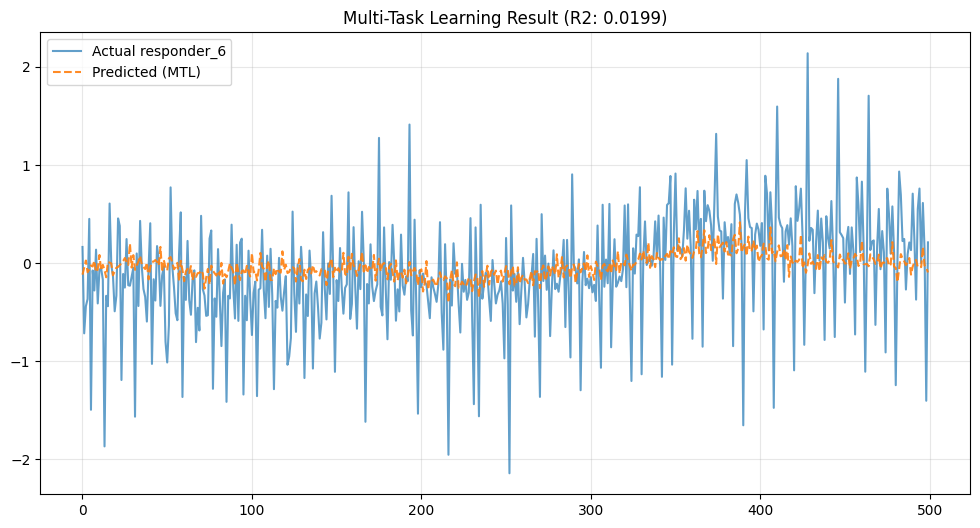

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, Input, mixed_precision
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score


# GPU 设置与混合精度
print("TensorFlow Version:", tf.__version__)

# 检查 GPU 是否可用
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # 开启显存动态增长，防止一下子占满显存导致报错
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPU Detected: {len(gpus)} device(s). Training will use GPU.")

        # 开启混合精度 (Mixed Precision) - 加速训练并减少显存占用
        policy = mixed_precision.Policy('mixed_float16')
        mixed_precision.set_global_policy(policy)
        print(f"Mixed Precision enabled: {policy.name}")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU detected. Training will be slow on CPU.")


# 数据准备
def prepare_mtl_data(df):

    # 假设 df 是已经包含 feature_XX 和 responder_XX 的数据框
    target_cols = ['responder_6', 'responder_7', 'responder_8']
    feature_cols = [c for c in df.columns if 'feature_' in c]

    # 移除空值
    df_clean = df.dropna(subset=target_cols + feature_cols).reset_index(drop=True)
    return df_clean, feature_cols, target_cols


# 构建 MTL 模型
def build_mtl_model(input_dim):

    # 输入层
    inputs = Input(shape=(input_dim,), name='input_features')

    # 共享骨干网络
    x = layers.Dense(256, activation='swish')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Dense(128, activation='swish')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    shared_features = layers.Dense(64, activation='swish')(x)


    # 独立任务头

    # Head A: Main Target (Responder 6)
    r6_branch = layers.Dense(32, activation='swish')(shared_features)
    output_r6 = layers.Dense(1, name='pred_r6', dtype='float32')(r6_branch)

    # Head B: Long-term Aux (Responder 7)
    r7_branch = layers.Dense(32, activation='swish')(shared_features)
    output_r7 = layers.Dense(1, name='pred_r7', dtype='float32')(r7_branch)

    # Head C: Short-term Aux (Responder 8)
    r8_branch = layers.Dense(32, activation='swish')(shared_features)
    output_r8 = layers.Dense(1, name='pred_r8', dtype='float32')(r8_branch)



    model = models.Model(inputs=inputs, outputs=[output_r6, output_r7, output_r8])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        # 指定每个输出的 Loss

        loss={
            'pred_r6': 'mse',
            'pred_r7': 'mse',
            'pred_r8': 'mse'
        },
        # 主任务 R6 最重要
        loss_weights={
            'pred_r6': 1.0,
            'pred_r7': 0.5,
            'pred_r8': 0.5
        },
        metrics={
            'pred_r6': 'mae',
            'pred_r7': 'mae',
            'pred_r8': 'mae'
        }
    )

    return model



# A. 获取数据
df = df_cleaned

df_clean, features, targets = prepare_mtl_data(df)

# B. 切分数据
split_idx = int(len(df_clean) * 0.8)
train_df = df_clean.iloc[:split_idx]
test_df = df_clean.iloc[split_idx:]

X_train = train_df[features].values
X_test = test_df[features].values

Y_train = {
    'pred_r6': train_df['responder_6'].values,
    'pred_r7': train_df['responder_7'].values,
    'pred_r8': train_df['responder_8'].values
}
Y_test = {
    'pred_r6': test_df['responder_6'].values,
    'pred_r7': test_df['responder_7'].values,
    'pred_r8': test_df['responder_8'].values
}

# C. 标准化
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# D. 构建模型
model = build_mtl_model(input_dim=len(features))

# E. 设置 Early Stopping
early_stopping = callbacks.EarlyStopping(
    monitor='val_pred_r6_loss',
    mode='min',                # 告诉 Keras Loss 越小越好
    patience=10,               # 增加 patience
    restore_best_weights=True,
    verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_pred_r6_loss',
    mode='min',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

print("开始训练多任务模型 (GPU Optimized)...")


history = model.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    epochs=50,
    batch_size=2048,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


# 预测
print("\n正在生成预测...")
preds = model.predict(X_test, batch_size=4096)
pred_r6 = preds[0].flatten() # Index 0 是 pred_r6

# 计算 R2
r2 = r2_score(test_df['responder_6'], pred_r6)
print(f"Test R2 Score (Responder 6): {r2:.5f}")

# 绘图
plt.figure(figsize=(12, 6))

plt.plot(test_df['responder_6'].values[:500], label='Actual responder_6', alpha=0.7)  # color='gray'
plt.plot(pred_r6[:500], label='Predicted (MTL)', alpha=0.9, linestyle='--')

plt.title(f'Multi-Task Learning Result (R2: {r2:.4f})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
mse = mean_squared_error(test_df['responder_6'], pred_r6)
rmse = np.sqrt(mse)

print(f"Test MSE (Responder 6): {mse:.5f}")
print(f"Test RMSE (Responder 6): {rmse:.5f}")

Test MSE (Responder 6): 0.97308
Test RMSE (Responder 6): 0.98645


正在计算长周期与深层滞后指标...
有效样本数: 1941810


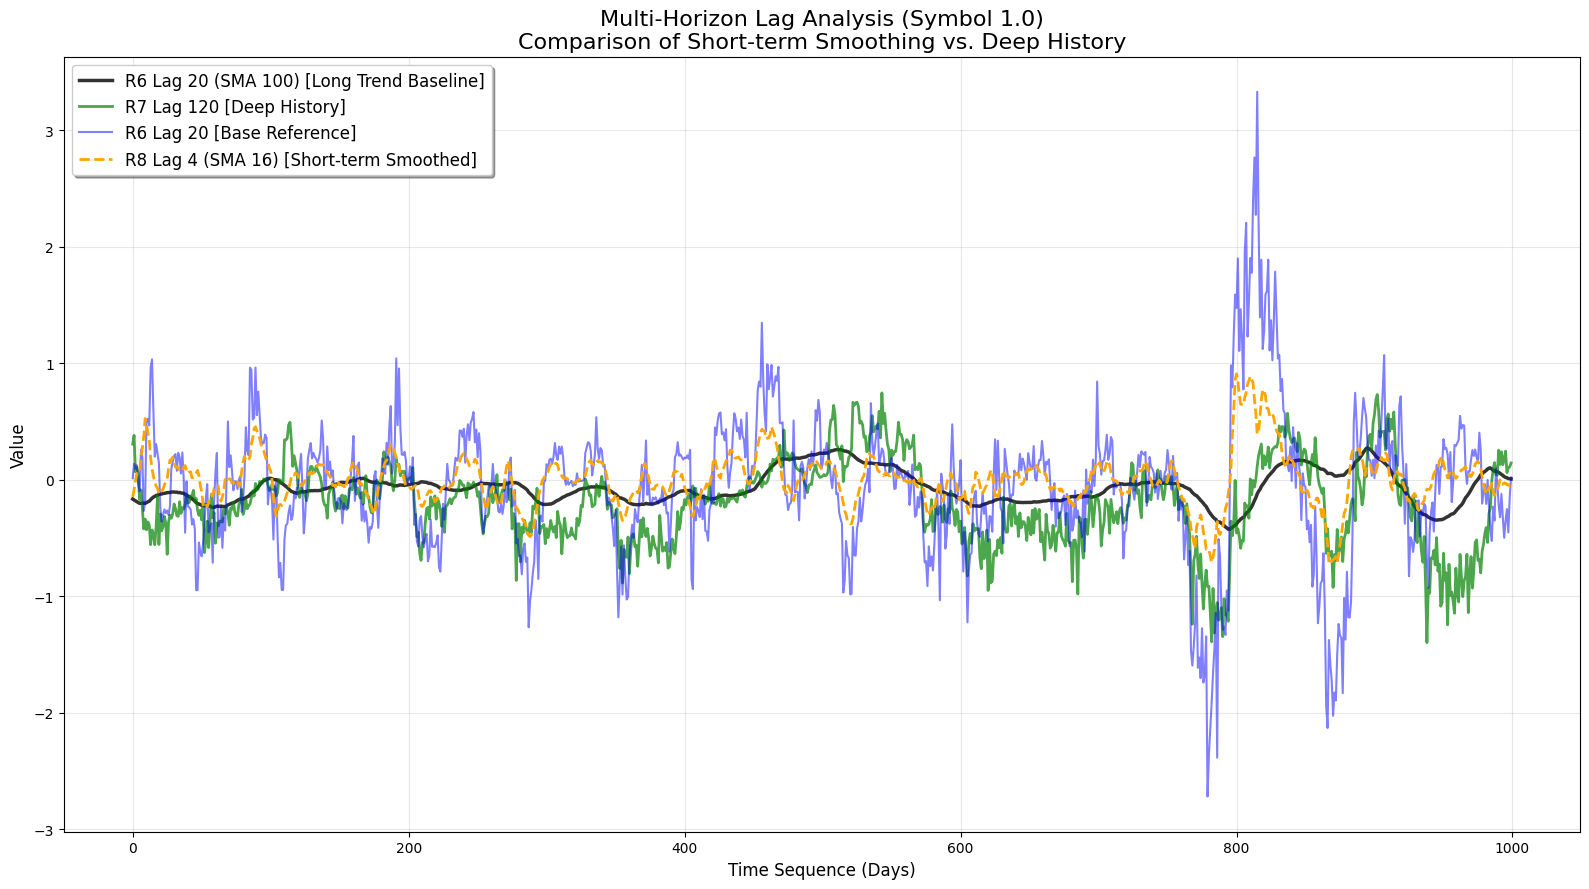

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_deep_history_comparison(df):
    print("正在计算长周期与深层滞后指标...")

    # 我们需要 r6, r7, r8
    chk_df = df[['date_id', 'symbol_id', 'responder_6', 'responder_7', 'responder_8']].copy()
    chk_df.sort_values(['symbol_id', 'date_id'], inplace=True)

    # 2. 构建特征
    grouped = chk_df.groupby('symbol_id')

    # Variable A: R6 Lag 20 (作为主要对比对象)
    chk_df['r6_lag20'] = grouped['responder_6'].shift(20)

    # Variable B: R8 Lag 4 -> SMA 16
    chk_df['r8_lag4'] = grouped['responder_8'].shift(4)
    chk_df['r8_lag4_sma16'] = chk_df.groupby('symbol_id')['r8_lag4'].transform(
        lambda x: x.rolling(window=16, min_periods=16).mean()
    )

    # 在 Lag 20 的基础上，再取 100 天的移动平均
    chk_df['r6_lag20_sma100'] = chk_df.groupby('symbol_id')['r6_lag20'].transform(
        lambda x: x.rolling(window=100, min_periods=100).mean()
    )

    # 直接取 R7 的 120 天滞后
    chk_df['r7_lag120'] = grouped['responder_7'].shift(120)

    # 由于 SMA 100 和 Lag 120 的存在，每个 Symbol 前 ~120-140 行会变为空值，移除
    cols_to_plot = ['r6_lag20', 'r8_lag4_sma16', 'r6_lag20_sma100', 'r7_lag120']
    valid_df = chk_df.dropna(subset=cols_to_plot)

    print(f"有效样本数: {len(valid_df)}")

    # 可视化
    if len(valid_df) > 0:

        # 选取数据最多的 Symbol
        sample_symbol = valid_df['symbol_id'].value_counts().idxmax()

        # 取出该 Symbol 的数据，重置索引
        sample_data = valid_df[valid_df['symbol_id'] == sample_symbol].copy()

        # 截取中间 1000 个点
        display_len = min(1000, len(sample_data))
        start_idx = len(sample_data) // 2 - display_len // 2
        sample_data = sample_data.iloc[start_idx : start_idx + display_len].reset_index(drop=True)

        plt.figure(figsize=(16, 9))

        # 1. R6 Lag 20 (SMA 100) - 黑色粗线，长期趋势
        plt.plot(sample_data.index, sample_data['r6_lag20_sma100'],
                 label='R6 Lag 20 (SMA 100) [Long Trend Baseline]', color='black', linewidth=2.5, alpha=0.8)

        # 2. R7 Lag 120 - 绿色线，历史记忆
        plt.plot(sample_data.index, sample_data['r7_lag120'],
                 label='R7 Lag 120 [Deep History]',
                 color='green', linewidth=2, alpha=0.7)

        # 3. R6 Lag 20 (Base) - 蓝色细实线，滞后
        plt.plot(sample_data.index, sample_data['r6_lag20'],
                 label='R6 Lag 20 [Base Reference]',
                 color='blue', linewidth=1.5, alpha=0.5)

        # 4. R8 Lag 4 SMA 16 - 橙色虚线，近期信号
        plt.plot(sample_data.index, sample_data['r8_lag4_sma16'],
                 label='R8 Lag 4 (SMA 16) [Short-term Smoothed]', color='orange', linestyle='--', linewidth=2)

        plt.title(f'Multi-Horizon Lag Analysis (Symbol {sample_symbol})\nComparison of Short-term Smoothing vs. Deep History', fontsize=16)
        plt.xlabel('Time Sequence (Days)', fontsize=12)
        plt.ylabel('Value', fontsize=12)

        plt.legend(fontsize=12, loc='best', frameon=True, shadow=True)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

# 运行绘图
plot_deep_history_comparison(df_cleaned)